# ML Challenge Problem 6 Part 5

In this notebook I decided to try straight up calculating the pedestal vsalues by just averaging all samples that lie within a band around zero. This should cut out the majority of any actual pulses or noise. Th thinking is that this could be a pretty accurate estimate that when fed to a model with the waveform itself, would allow the model to focus solely on calculating a correction.

The first thing to do (as always) is read in the data.

In [1]:
# Read the full data file into a dataframe
# This file does not have a header so we define the column names here explicitly

import pandas as pd
import numpy as np

TRAIN_FILE  = '/home/davidl/work2/2020.08.12.ML_challenge6/Aug_2020_ML_train.csv'

# Columns in input file. First 5 are labels
names = ['ped', 'A1', 'A2', 't1', 't2']

# Next 128 are features (waveform)
for i in range(0,128): names.append('s%03d' % i)

# Read file and print how many waveforms are found
df = pd.read_csv(TRAIN_FILE, names=names)
print('Number of waveforms: %d' % len(df.index))

Number of waveforms: 190071


### Define non-trainable Model

Here I define a model with a single Lambda layer. It calls the CalcPed procedure which calculates the average for all samples within the specified band. Since there are no trainable parameters, I don't need to fit the model. I can simply predict with it and compare the results with the labels.

In [2]:
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Reshape, Flatten, Input, Lambda, Conv1D
from tensorflow.keras.optimizers import SGD, Adamax, Adadelta, Adam
from tensorflow.keras.callbacks import Callback, TensorBoard
import tensorflow.keras.backend as K
import tensorflow.keras.losses
import tensorflow as tf
import matplotlib.pyplot as plt

NINPUTS = 128

#-----------------------------------------------------
# CalcPed
#-----------------------------------------------------
def CalcPed(inputs, vmin=-30.0, vmax=100.0):
    
    # Calculate mask of values in the inputs that fall between the minimum and maximum
    min_mask = vmin*K.ones_like(inputs)
    min_mask = K.cast_to_floatx(K.greater(inputs, min_mask))
    max_mask = vmax*K.ones_like(inputs)
    max_mask = K.cast_to_floatx(K.less(inputs, max_mask))

    # Combine upper and lower limit masks into single mask of values to average and apply
    mask = min_mask*max_mask
    sparse_waveforms = inputs * mask

    # Find average of elements not filtered by mask
    Nvals = K.sum(mask, axis=1)
    Sum = K.sum(sparse_waveforms, axis=1)
    
    avg = tf.math.divide_no_nan(Sum, Nvals)
    ped = K.expand_dims(avg)
    
    return -ped   # minus sign  is because waveform is sign inverted

#-----------------------------------------------------
# DefineModel
#-----------------------------------------------------
# This is used to define the model. It is only called if no model
# file is found in the model_checkpoints directory.
def DefineModel():
    
    vmin = -100
    vmax = 15

    inputs  = Input(shape=(NINPUTS,1), name='waveform')
    x = Lambda(CalcPed, arguments={'vmin':vmin, 'vmax':vmax})(inputs)
    outputs = Reshape((1,))(x)

    model   = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='mse', optimizer=Adam(), metrics=['mae', 'mse'])

    return model

model = DefineModel()
model.summary()

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-vczedisu because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
waveform (InputLayer)        [(None, 128, 1)]          0         
_________________________________________________________________
lambda (Lambda)              (None, 1, 1)              0         
_________________________________________________________________
reshape (Reshape)            (None, 1)                 0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


### Test Calculation Model

Here I use the model to calculate the pedestal and compare it to the labels. I make 2 histograms. The one on the left to show the difference between predicted and truth. The one on the right to show sample values. The one on the right gives me an idea of where to place the cuts on the waveform for samples to include in the average.

In the end, I played with the cuts empirically to try and minimize the rms.

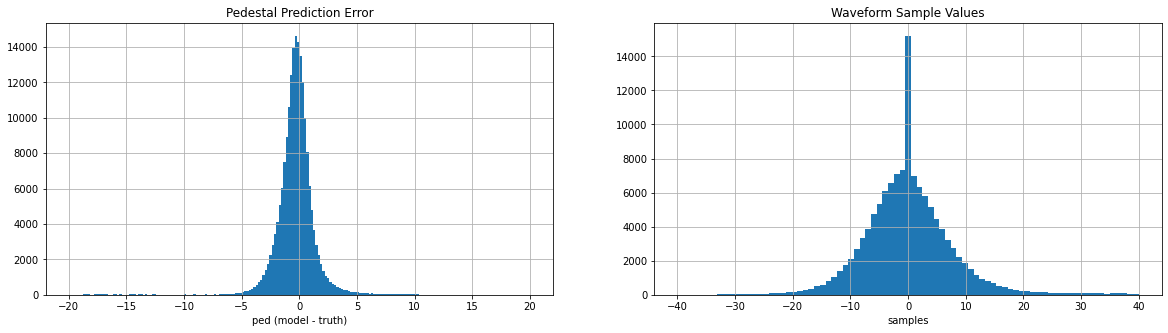

mean: -0.269164   rms: 3.469881


In [3]:
# Test model
mydf = df
y_labels = mydf.loc[:,['ped']].to_numpy()
x_waveform = mydf.iloc[:,5:133].mul(-1)

y_pred = model.predict(x_waveform)

y_diff = np.squeeze(y_pred - y_labels)

fig,ax = plt.subplots(1,2, figsize=(20,5))
ax[0].hist(y_diff, range=(-20.0,20.0), bins=200)
ax[0].grid()
ax[0].set_title('Pedestal Prediction Error')
ax[0].set_xlabel('ped (model - truth)')

x_waveform_sample = np.reshape(x_waveform[:1000].to_numpy(), (128000,))
ax[1].hist(x_waveform_sample, range=(-40.0,40.0), bins=81)
ax[1].grid()
ax[1].set_title('Waveform Sample Values')
ax[1].set_xlabel('samples')

plt.show()

# Calculate rms and mean
mean = np.mean(y_diff)
rms = np.sqrt(np.mean(y_diff**2))
print('mean: %f   rms: %f' % (mean,rms))

# Predicting Number of pulses

One of the criteria of the problem was to acurrately predict the number of pulses in the waveform. Here I want to train a model that does just that. The first thing I will need though is a column in the dataframe that has this value.



In [4]:
vA1 = df['A1'].to_numpy()
vA2 = df['A2'].to_numpy()
Npulses = 1*(vA1>0.) + 1*(vA2>0.)
unique, counts = np.unique(Npulses, return_counts=True)
print('Number 0, 1, and 2 pulse waveforms: ' + str(counts))

# Add column with number of pulses
df['Npulses'] = Npulses

# Make slices containing only 0,1,2 identified pulses
dfno_pulses = df[(df.A1==0) & (df.A2==0)]
dfone_pulse = df[(df.A1!=0) & (df.A2==0)]
dftwo_pulse = df[(df.A1!=0) & (df.A2!=0)]


Number 0, 1, and 2 pulse waveforms: [126000  63000   1071]


### Define model

In [34]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Reshape, Flatten, Input, Lambda, Conv1D
from tensorflow.keras.optimizers import SGD, Adamax, Adadelta
from tensorflow.keras.callbacks import Callback, TensorBoard
import tensorflow.keras.backend as K
import tensorflow.keras.losses
import tensorflow as tf

def customLoss(y_true, y_pred):
    y_diff = K.round(y_pred) - y_true
    y_loss = y_diff*y_diff
    return y_loss

inputs     = Input(shape=(NINPUTS,1), name='waveform')
x = Conv1D(128,(32), name='Npulse_conv_layer1', activation='tanh')(inputs)
x = Conv1D(32,(16), name='Npulse_conv_layer2', activation='tanh')(x)
x = Conv1D(32,(4), name='Npulse_conv_layer3', activation='relu')(x)
x = Flatten(name='Npulse_flatten')(x)
x = Dense(32, name='Npulse_layer1', activation='linear')(x)
x = Dense(64, name='Npulse_layer2', activation='tanh')(x)
x = Dense(32, name='Npulse_layer3', activation='linear')(x)
x = Dense(32, name='Npulse_layer4', activation='tanh')(x)
x = Dense(8, name='Npulse_layer5', activation='linear')(x)
outputs = Dense(3, name='Npulse_output', activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

#opt = Adam()
opt = Adadelta(clipnorm=1, learning_rate=0.002, rho=0.98)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'], weighted_metrics=['accuracy'])

Model: "functional_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
waveform (InputLayer)        [(None, 128, 1)]          0         
_________________________________________________________________
Npulse_conv_layer1 (Conv1D)  (None, 97, 128)           4224      
_________________________________________________________________
Npulse_conv_layer2 (Conv1D)  (None, 82, 32)            65568     
_________________________________________________________________
Npulse_conv_layer3 (Conv1D)  (None, 79, 32)            4128      
_________________________________________________________________
Npulse_flatten (Flatten)     (None, 2528)              0         
_________________________________________________________________
Npulse_layer1 (Dense)        (None, 32)                80928     
_________________________________________________________________
Npulse_layer2 (Dense)        (None, 64)              

### Fit Model

In [35]:
mydf = df
y_labels      = mydf['Npulses']   # Peel off only 5 labels
y_cat_labels  = tf.keras.utils.to_categorical( y_labels, 3 )
x_waveform    = mydf.iloc[:,5:133]  # Peel off 128 waveform samples

# account for imbalanced samples
no_pulse_weight  = len(df)/len(dfno_pulses)
one_pulse_weight = len(df)/len(dfone_pulse)
two_pulse_weight = len(df)/len(dftwo_pulse)
class_weight = {0:no_pulse_weight, 1:one_pulse_weight, 2:two_pulse_weight}
print('class_weight: ' + str(class_weight))

BATCH  = 4
EPOCHS = 100

early_stopping = tf.keras.callbacks.EarlyStopping(
    'val_mae',
    min_delta=0.002,
    patience=3,
    restore_best_weights=True,
    verbose=1
)

model.fit(x_waveform, y_cat_labels, class_weight=class_weight, batch_size=BATCH, epochs=EPOCHS, validation_split=0.2)

class_weight: {0: 1.5085, 1: 3.017, 2: 177.47058823529412}
Epoch 1/100
38014/38014 [==============================] - 253s 7ms/step - loss: 5.2960 - accuracy: 0.9780 - weighted_accuracy: 0.6533 - val_loss: 0.0545 - val_accuracy: 0.9893 - val_weighted_accuracy: 0.9893
Epoch 2/100
38014/38014 [==============================] - 254s 7ms/step - loss: 5.6057 - accuracy: 0.9896 - weighted_accuracy: 0.6622 - val_loss: 0.0538 - val_accuracy: 0.9898 - val_weighted_accuracy: 0.9898
Epoch 3/100
38014/38014 [==============================] - 254s 7ms/step - loss: 5.4317 - accuracy: 0.9899 - weighted_accuracy: 0.6625 - val_loss: 0.0511 - val_accuracy: 0.9900 - val_weighted_accuracy: 0.9900
Epoch 4/100
38014/38014 [==============================] - 235s 6ms/step - loss: 5.1997 - accuracy: 0.9901 - weighted_accuracy: 0.6627 - val_loss: 0.0500 - val_accuracy: 0.9902 - val_weighted_accuracy: 0.9902
Epoch 5/100
38014/38014 [==============================] - 252s 7ms/step - loss: 5.0092 - accuracy: 0.990

In [6]:
model.save('2020.11.01.Npulses')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: 2020.10.31.Npulses/assets


Check the accuracy of the model in predicting the number of pulses

In [7]:
y_true = df['Npulses'].to_numpy()
y_pred = model.predict(mydf.iloc[:,5:133])
y_pred = np.squeeze(np.round(y_pred))

In [10]:
y_diff = y_pred - y_true
testdf = pd.DataFrame({'y_diff':y_diff, 'y_true':y_true, 'y_pred':y_pred})

N_zero_pulse = len(testdf[ (testdf['y_true']==0) ])
N_one_pulse = len(testdf[ (testdf['y_true']==1) ])
N_two_pulse = len(testdf[ (testdf['y_true']==2) ])

Ngood_zero_pulse = len(testdf[ (testdf['y_diff']==0) & (testdf['y_true']==0) ])
Ngood_one_pulse = len(testdf[ (testdf['y_diff']==0) & (testdf['y_true']==1) ])
Ngood_two_pulse = len(testdf[ (testdf['y_diff']==0) & (testdf['y_true']==2) ])

Nbad_zero_pulse = len(testdf[ (testdf['y_diff']!=0) & (testdf['y_true']==0) ])
Nbad_one_pulse = len(testdf[ (testdf['y_diff']!=0) & (testdf['y_true']==1) ])
Nbad_two_pulse = len(testdf[ (testdf['y_diff']!=0) & (testdf['y_true']==2) ])

percent_bad_zero_pulse = 100.0*Nbad_zero_pulse/(Nbad_zero_pulse+Ngood_zero_pulse)
percent_bad_one_pulse = 100.0*Nbad_one_pulse/(Nbad_one_pulse+Ngood_one_pulse)
percent_bad_two_pulse = 100.0*Nbad_two_pulse/(Nbad_two_pulse+Ngood_two_pulse)

print('Total waveforms: %d  (%d - 0 pulse, %d - 1 pulse, %d - 2 pulse)' % (len(testdf), N_zero_pulse, N_one_pulse, N_two_pulse))
print('Zero pulse waveforms: %d correct, %d incorrect (%3.1f%%)' % (Ngood_zero_pulse, Nbad_zero_pulse, percent_bad_zero_pulse))
print('One pulse waveforms: %d correct, %d incorrect (%3.1f%%)' % (Ngood_one_pulse, Nbad_one_pulse, percent_bad_one_pulse))
print('Two pulse waveforms: %d correct, %d incorrect (%3.1f%%)' % (Ngood_two_pulse, Nbad_two_pulse, percent_bad_two_pulse))

Total waveforms: 190071  (126000 - 0 pulse, 63000 - 1 pulse, 1071 - 2 pulse)
Zero pulse waveforms: 124223 correct, 1777 incorrect (1.4%)
One pulse waveforms: 61706 correct, 1294 incorrect (2.1%)
Two pulse waveforms: 0 correct, 1071 incorrect (100.0%)
